# RL - Assignment (RLI_09, DRL_05)
## Off-Policy MC Control with Weighted Importance Sampling

<div class="alert alert-info"><strong>
Review the notebook and fill in the missing code appropriately.<br>
Check the final executability and results of the resulting code.
</strong></div>

### Placeholders for filling answers
✏️level⭐<br>
**or**<br>
✏️level⭐optional info📄<br>
_level_ = estimated level of difficulty (may also be related to the relative scoring of the question)<br>
_optional info_ = optional hint or description of the question (might be ommitted)<br>
**example:**<br>
z = x + ✏️1⭐name of the appropriate variable📄<br>
the expected response should be also a line of code just replacing the placeholder with the proposed solution<br>
Do not change anything else (even spaces) within the line!<br>
**example solution line:**<br>
z = x + y<br>

In [5]:
# Placeholders for filling answers
# ✏️level⭐
# or
# ✏️level⭐optional info📄
# level = estimated level of difficulty (may also be related to the relative scoring of the question)
# optional info = optional hint or description of the question (might be ommitted)
# example: 
# z = x + ✏️1⭐name of the appropriate variable📄
# the expected response should be also a line of code just replacing the placeholder with the proposed solution
# Do not change anything else (even spaces) within the line!
# example solution line:
# z = x + y

In [6]:
%matplotlib inline

import matplotlib
import numpy as np
import sys

from collections import defaultdict
from blackjack_gym import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [ ]:
# OpenAI compliant environment version > 0.26.0
# WARNING!!! 
# suggested installation: pip install gymnasium
# create and use a virtual environment if conflicts
env = BlackjackEnv()

In [13]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation): # arg not used...
        return A
    return policy_fn

In [9]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A[best_action] = 1.0
        return A
    return policy_fn

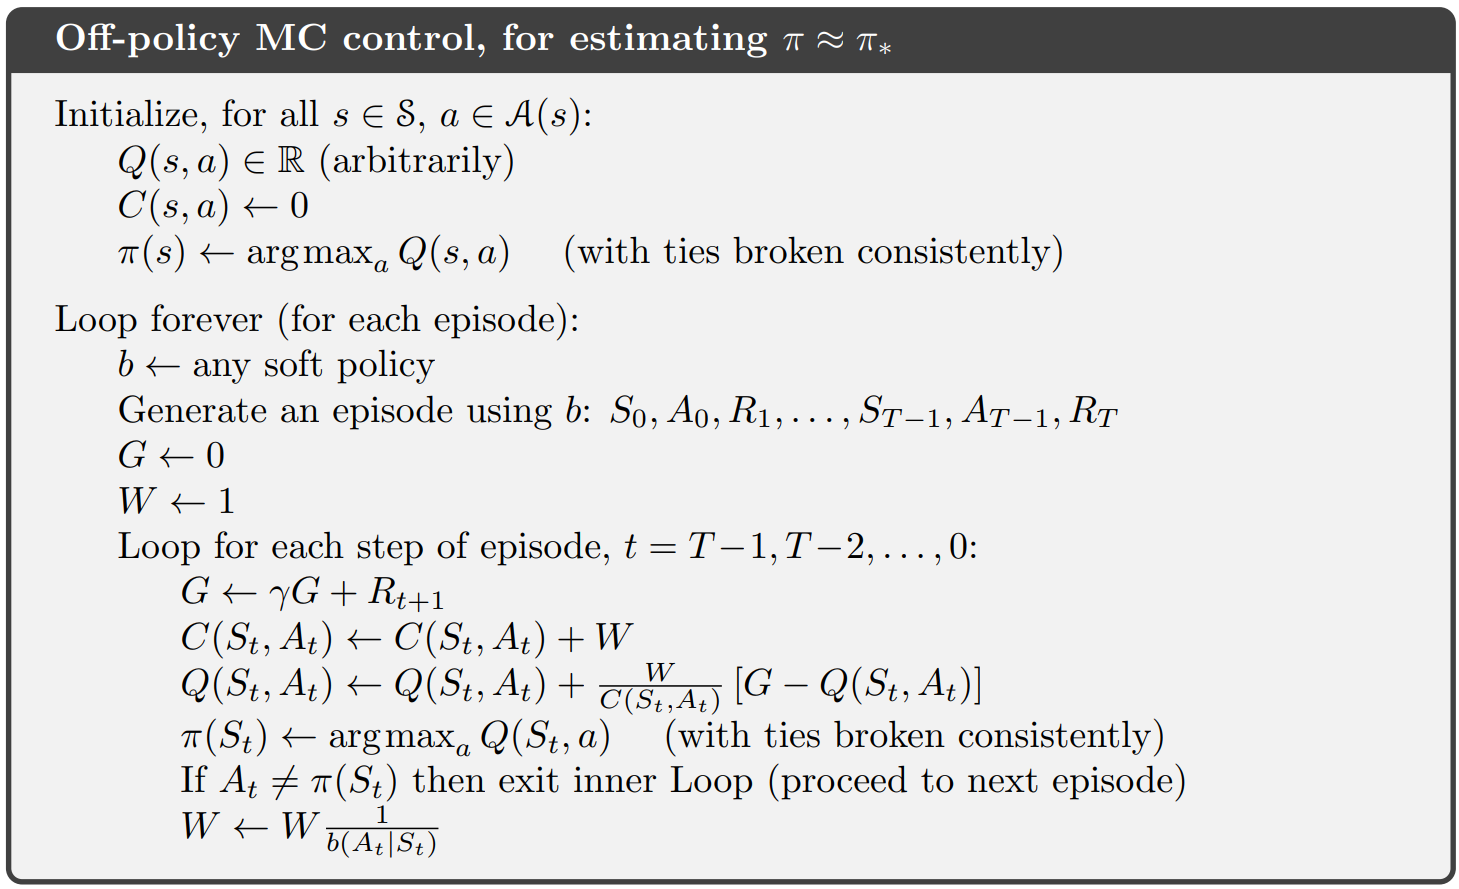

In [10]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # The cumulative denominator of the weighted importance sampling formula
    # (across all episodes)
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
        
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state, _ = env.reset()
        for t in range(100):
            # Sample an action from our policy
            probs = behavior_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs) # sample an action
            next_state, reward, terminated, truncated, _ = env.step(action) # execute action, get next state and reward (and eventual termination)
            done = terminated or truncated
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        # Sum of discounted returns
        G = 0.0
        # The importance sampling ratio (the weights of the returns)
        W = 1.0
        # For each step in the episode, backwards
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            # Update the total reward since step t
            G = discount_factor * G + reward
            # Update weighted importance sampling formula denominator
            C[state][action] += W
            # Update the action-value function using the incremental update formula (5.7)
            # This also improves our target policy which holds a reference to Q
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            # If the action taken by the behavior policy is not the action 
            # taken by the target policy the probability will be 0 and we can break
            if action != np.argmax(target_policy(state)):
                break
            W = W * 1./behavior_policy(state)[action]
        
    return Q, target_policy

## Main

In [11]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, 
                                           num_episodes=500000, 
                                           behavior_policy=random_policy)

Episode 500000/500000.

## Plot results

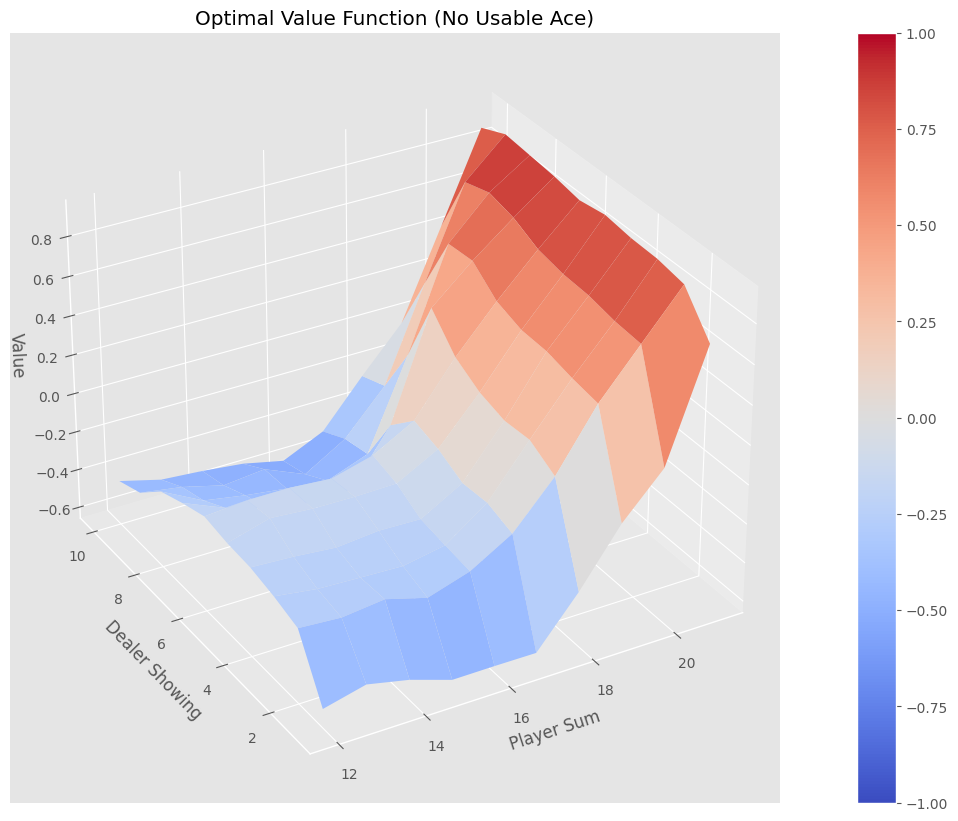

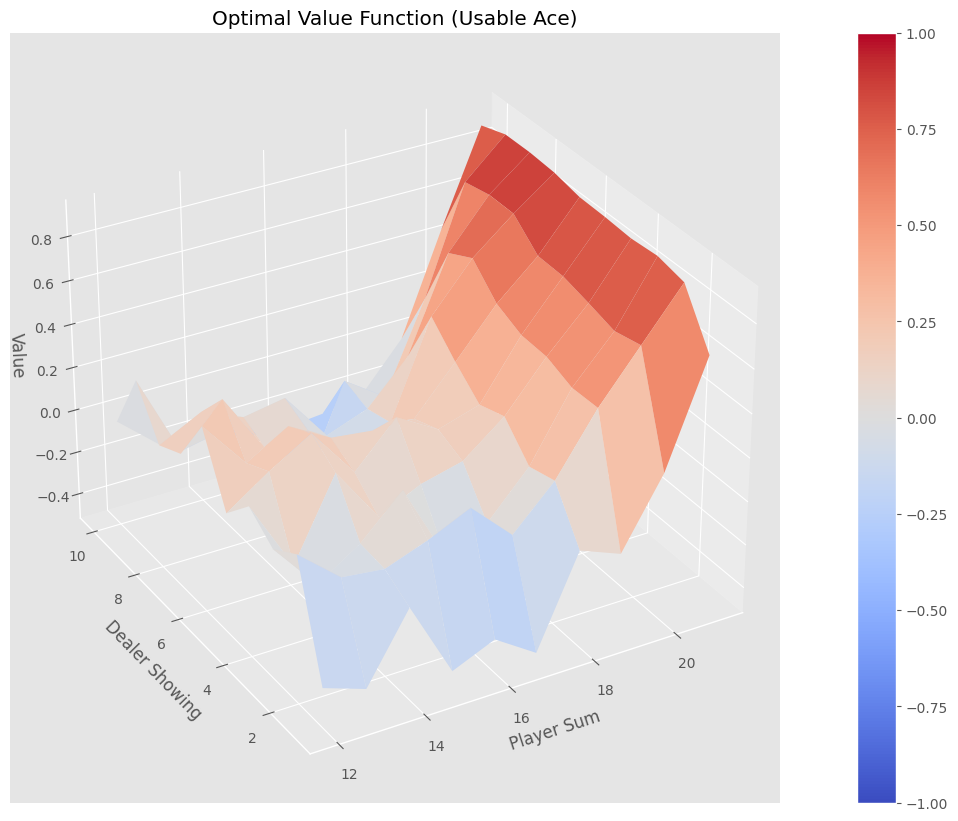

In [12]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")